In [2]:
import numpy as np
import math
import cv2
from matplotlib import pyplot as plt

## Загрузка изображения

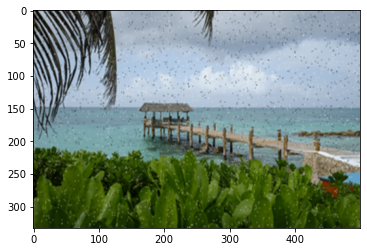

In [3]:
image = cv2.imread("saltpepper.png")
image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
plt.imshow(image)

## Функция проверяющая пиксель на выход за пределы картинки

In [4]:
def Clamp (value: int, min: int, max: int) -> int:
    if value < min:
        return min
    if value > max:
        return max
    return value

## Медианный фильтр

In [5]:
def MedianFilter (source_image: np.ndarray, x: int, y: int, s: int) -> (int, int, int):
    radiusX = s // 2
    radiusY = s // 2
    colors = np.zeros(((2 * (s // 2) + 1) ** 2, 3))
    values = np.array([], dtype = int)
    height, width, _ = source_image.shape
    cur = 0
    for i in range (-radiusX, radiusX + 1):
        for j in range (-radiusY, radiusY + 1):
            idX = Clamp(x + i, 0, height - 1)
            idY = Clamp(y + j, 0, width - 1)
            red, green, blue = source_image[idX][idY]
            colors[cur] = [red, green, blue]
            cur += 1
            values = np.append(values, red // 3 + green // 3 + blue // 3)
    values = np.sort(values)  
    mid = ((2 * (s // 2) + 1) ** 2) // 2
    mid_val = values[mid]
    for pixel in colors:
        red, green, blue = pixel
        if red // 3 + green // 3 + blue // 3 == mid_val:
            return (red, green, blue) 

### Функция, применяющая медианный фильтр к каждому пикселю

In [6]:
def Median_Use(image: np.ndarray, param = 2) -> np.ndarray:
    height, width, _ = image.shape
    new_image = image.copy() 
    for i in range(height):
        for j in range(width):
               new_image[i][j] = MedianFilter(image, i, j, param)
    return new_image

Картинка из np.ndarray переведена в list, так как итерация по массиву ndarray очень трудоемкая

### Наша функция с параметром по умолчанию 2

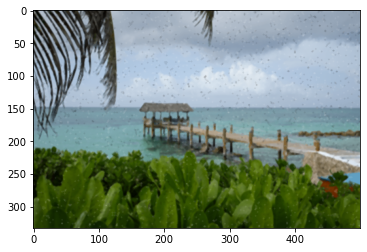

In [7]:
new_img_two = Median_Use(image)
plt.imshow(new_img_two)

### Наша функция с параметром 4

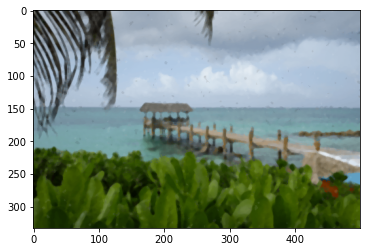

In [8]:
new_img = Median_Use(image, 4)
plt.imshow(new_img)

### Встроенная функция medianBlur с параметром 3

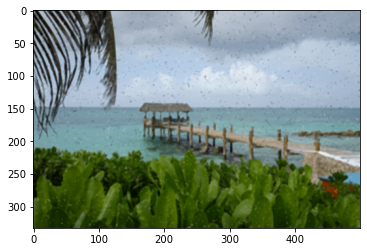

In [20]:
med = cv2.medianBlur(image, 3)
plt.imshow(med)

### Встроенная функция medianBlur с параметром 5

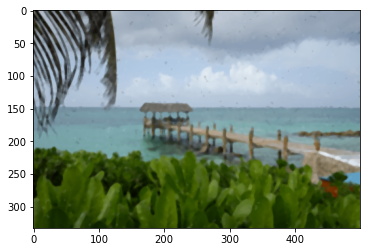

In [23]:
med_two = cv2.medianBlur(image, 5)
plt.imshow(med_two)

## Сравнение нашей функции и встроенной

### Функция измерения времени работы функции

In [10]:
from timeit import default_timer as timer


def measure_time(callable, *args, max_time=5, num_measures=10, percent_skip=20, **kwargs):
    t0 = timer()
    result = callable(*args, **kwargs)
    time = timer() - t0

    if time > max_time:
        return (time, result)

    times = []
    for i in range(num_measures):
        t0 = timer()
        _ = callable(*args, **kwargs)
        times.append(timer() - t0)

    le = int(num_measures*percent_skip/100)
    ri = num_measures - le
    cnt = ri - le + 1
    sum = 0
    while le <= ri:
        sum += times[le]
        le += 1

    return (sum / cnt, result)

### Время работы нашей функции

In [11]:
time, _ = measure_time(Median_Use, image)
print (time)

59.871451000000036


### Время работы встроенной функции

In [12]:
time, _ = measure_time(cv2.medianBlur, image, 1)
print (time)

5.5942857142911506e-05


## Сравнение сходства двух изображений

### Функции сравнения

In [13]:
def immse(fi_image: np.ndarray, se_image: np.ndarray) -> float:
    return ((fi_image - se_image) ** 2).mean()

def psnr(fi_image: np.ndarray, se_image: np.ndarray) -> float:
    mse = immse(fi_image, se_image)
    if mse == 0:
        return 100.0
    return 10 * math.log((255.0 * 255.0 / mse), 10)


def ssim(fi_image: np.ndarray, se_image: np.ndarray) -> float:
    fi_image.flatten()
    se_image.flatten()
    intensity_fi = fi_image.mean()  # Математическое ожидание (среднее арифметическое)
    intensity_se = se_image.mean()  # Математическое ожидание (среднее арифметическое)
    contrast_fi = fi_image.var()  # Среднеквадратическое отклонение (дисперсия)
    contrast_fi = contrast_fi ** 0.5
    contrast_se = se_image.var()  # Среднеквадратическое отклонение (дисперсия)
    contrast_se = contrast_se ** 0.5
    const_fi = 0.0003
    const_se = 0.0005
    koef_l = (2 * intensity_fi * intensity_se + const_fi) / \
        (intensity_fi ** 2 + intensity_se ** 2 + const_fi)
    if fi_image.shape == 2:
        covariance = numpy.cov(fi_image, se_image)  # Ковариация двух случайных величин
        koef_c = (2 * covariance + const_se) / \
            (contrast_fi ** 2 + contrast_se ** 2 + const_se)
        return (koef_l/koef_c).mean()
    koef_c = (2 * contrast_se * contrast_fi + const_se) / \
        (contrast_fi ** 2 + contrast_se ** 2 + const_se)
    return koef_l * koef_c

### Сходство по psnr

In [14]:
print (psnr(new_img_two, med))

35.89754603088318


In [25]:
print (psnr(new_img, med_two))

42.69218551331992


### Сходство по ssim

In [26]:
print (ssim(new_img_two, med))

0.9999998786517331


In [27]:
print (ssim(new_img, med_two))

0.9999997645685283
